In [1]:
import os
import json
import pandas as pd

In [2]:
os.chdir("..")

#### Importação Bibliotecas

In [3]:
from calysto.utils import load_settings
from calysto.feature_engineering import Engineering
from calysto.model_selection import Training
from calysto.submission import KaggleSubmission

#### Load Settings

In [4]:
kaggle_params = json.load(open("settings/main.json", "r"))
model_params = json.load(open("settings/train.json", "r"))
feature_params = json.load(open("settings/dataprep_best.json", "r"))

In [5]:
model_params

[{'estimator': ["GradientBoostingRegressor(random_state=1903, loss='huber')"],
  'estimator__max_features': [3, 'sqrt', 'log2'],
  'estimator__n_estimators': [600, 700],
  'estimator__learning_rate': [0.08],
  'estimator__subsample': [0.5],
  'estimator__min_samples_split': [1, 2],
  'estimator__min_samples_leaf': [5, 4],
  'estimator__min_impurity_decrease': [0],
  'estimator__alpha': [0.2, 0.3]}]

#### Read Data

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

#### Feature Engineering

In [7]:
data = Engineering(train)

In [8]:
X = data.feature(feature_params)

In [9]:
y = data.target("SalePrice")

#### Model training

In [10]:
model = Training(X, y, model_params)

In [11]:
model.train_test_split()

In [12]:
model.gridsearch()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   44.7s finished


GridSearchCV(estimator=Pipeline(steps=[('estimator', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'estimator': [GradientBoostingRegressor(alpha=0.3,
                                                                  learning_rate=0.08,
                                                                  loss='huber',
                                                                  max_features='log2',
                                                                  min_impurity_decrease=0,
                                                                  min_samples_leaf=4,
                                                                  n_estimators=700,
                                                                  random_state=1903,
                                                                  subsample=0.5)],
                          'estimator__alpha': [0.2, 0.3],
                          'estimator__learning_rate': [0.08],
                

In [13]:
best_model = model.best()

In [14]:
model.results.best_params_

{'estimator': GradientBoostingRegressor(alpha=0.3, learning_rate=0.08, loss='huber',
                           max_features='log2', min_impurity_decrease=0,
                           min_samples_leaf=4, n_estimators=700,
                           random_state=1903, subsample=0.5),
 'estimator__alpha': 0.3,
 'estimator__learning_rate': 0.08,
 'estimator__max_features': 'log2',
 'estimator__min_impurity_decrease': 0,
 'estimator__min_samples_leaf': 4,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 700,
 'estimator__subsample': 0.5}

In [15]:
train_mse = model.metrics()

#### Validação

In [16]:
valid_mse = model.validate()

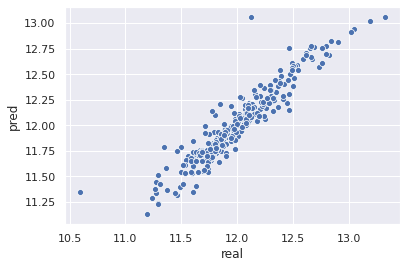

In [17]:
model.corrplot()

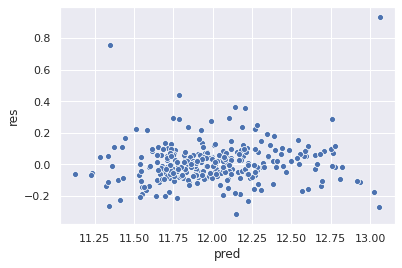

In [18]:
model.hetplot()

#### Predição do conjunto de teste

In [19]:
test_data = Engineering(test)

In [20]:
X_test = test_data.feature(feature_params)

In [21]:
y_pred_test = best_model.predict(X_test)

In [22]:
y_pred_test_transform = test_data.detarget(y_pred_test)

### Submissão ao Kaggle

In [23]:
predictions = KaggleSubmission(kaggle_params)

In [24]:
predictions.save(test, y_pred_test_transform)

'submissions/house-prices-advanced-regression-techniques-2020-Jul-21-21-43-58.csv'

In [30]:
predictions.submit(message = "feature_eng melhorada")

100%|██████████| 33.6k/33.6k [00:01<00:00, 19.0kB/s]


TypeError: 'str' object is not callable

### Versionamento do experimento

In [25]:
import neptune

In [26]:
neptune.init('adelmofilho/' + kaggle_params["competition_name"])

Project(adelmofilho/house-prices-advanced-regression-techniques)

In [27]:
neptune.create_experiment(name="new features", params={"feature": feature_params,
                                                       "model":model_params[0]})

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/adelmofilho/house-prices-advanced-regression-techniques/e/HOUSE-46


Experiment(HOUSE-46)

In [28]:
(train_mse, valid_mse)

(0.0024412706796342934, 0.016702943836509006)

In [29]:
neptune.log_metric('mean_squared_error_train',train_mse)
neptune.log_metric('mean_squared_error_valid',valid_mse)

In [31]:
neptune.log_metric('mean_squared_error_test', 0.12940)